In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
import pandas as pd
from glob import glob
from fastcore.xtras import load_pickle, save_pickle
from pathlib import Path

from sklearn.model_selection import train_test_split
from pycm import ConfusionMatrix
import optuna

import numpy as np
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
import time
import os
import shap

from plotutils.plotutils import *

plt.style.use("plotutils/kevin.mplstyle")


import matplotlib.pyplot as plt

from pymatgen.io.ase import AseAtomsAdaptor

from pymatgen.core import Structure

from visualization import create_atoms_with_color_arrays, show_atoms

In [4]:
# Classifier that performs optuna hyperopt in the fit call
class XGBoostOptunaClassifier(xgb.XGBClassifier):
    def __init__(self, n_trials=100, **kwargs):
        super().__init__(**kwargs)
        self.n_trials = n_trials

    def fit(self, X, y, seed, *args, **kwargs):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        def objective(trial):
            params = {
                "learning_rate": trial.suggest_float(
                    "learning_rate", 1e-2, 0.25, log=True
                ),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
                "subsample": trial.suggest_float("subsample", 0.1, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
                "max_depth": trial.suggest_int("max_depth", 1, 9),
                "n_estimators": trial.suggest_categorical(
                    "n_estimators", [7000, 15000, 20000]
                ),
            }

            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train,
                y_train,
                early_stopping_rounds=10,
                eval_set=[(X_val, y_val)],
                verbose=False,
            )

            y_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            return 1.0 - accuracy

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=self.n_trials)

        self.best_params_ = study.best_params
        super().set_params(**self.best_params_)

        return super().fit(X, y, *args, **kwargs)

In [5]:
all_data = pd.read_pickle("../data/all_data.pkl")
feature_names = load_pickle("../data/feature_names.pkl")
subset = all_data[all_data["below_benchmark"]]
feature_names = [f for f in all_data.columns if "phimage" in f]

In [30]:
subset['above_water_benchmark'] = ~subset['below_water_benchmark']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
train, test = train_test_split(
    subset, train_size=0.8, stratify=subset["below_water_benchmark"]
)

In [33]:
model = XGBoostOptunaClassifier(n_trials=100)
model.fit(
    train[feature_names].values, train["above_water_benchmark"].astype(int), seed=42
)

[I 2023-06-15 06:20:27,712] A new study created in memory with name: no-name-00530b8c-d81c-48ec-a73e-18e64baceb31
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2023-06-15 06:20:28,156] Trial 0 finished with value: 0.16129032258064513 and parameters: {'learning_rate': 0.03930799961108854, 'reg_lambda': 1.530495023208118e-06, 'reg_alpha': 26.123479303970253, 'subsample': 0.3143297894528756, 'colsample_bytree': 0.47154879576991715, 'max_depth': 4, 'n_estimators': 20000}. Best is trial 0 with value: 0.16129032258064513.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2023-06-15 06:20:28,888] Trial 1 finished with value: 0.09677419354838712 and parameters: {'learning_rate': 0.050216793920147836, 'reg_lambda': 9.077593626445795e-05, 'reg_alpha': 0.000323

[06:22:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_trials" } are not used.



XGBoostOptunaClassifier(base_score=None, booster=None, callbacks=None,
                        colsample_bylevel=None, colsample_bynode=None,
                        colsample_bytree=0.38602604712611466,
                        early_stopping_rounds=None, enable_categorical=False,
                        eval_metric=None, feature_types=None, gamma=None,
                        gpu_id=None, grow_policy=None, importance_type=None,
                        interaction_constraints=None,
                        learning_rate=0.03040206514583117, max_bin=None,
                        max_cat_threshold=None, max_cat_to_onehot=None,
                        max_delta_step=None, max_depth=3, max_leaves=None,
                        min_child_weight=None, missing=nan,
                        monotone_constraints=None, n_estimators=7000,
                        n_jobs=None, num_parallel_tree=None,
                        objective='binary:logistic', predictor=None, ...)

In [35]:
predictions = model.predict(test[feature_names])

In [36]:
cm = ConfusionMatrix(test["above_water_benchmark"].values.astype(int), predictions)

In [37]:
print(cm)

Predict  0        1        
Actual
0        64       0        

1        7        6        





Overall Statistics : 

95% CI                                                            (0.84488,0.9733)
ACC Macro                                                         0.90909
ARI                                                               0.51759
AUNP                                                              0.73077
AUNU                                                              0.73077
Bangdiwala B                                                      0.89399
Bennett S                                                         0.81818
CBA                                                               0.68147
CSI                                                               0.68147
Chi-Squared                                                       32.03467
Chi-Squared DF                                                    1
Conditional Entropy                                           

In [38]:
model = xgb.XGBClassifier(**model.best_params_)
model.fit(subset[feature_names].values, subset["above_water_benchmark"].astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.38602604712611466, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03040206514583117,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=7000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [39]:
save_pickle("../models/20230613-model-water-cement_all.pkl", model)

## Now, get the SHAP feature importance


In [40]:
explainer = shap.TreeExplainer(model)

In [43]:
shap_values = explainer.shap_values(
    subset[subset["above_water_benchmark"]].sort_values(
        by="water_resistance", ascending=True
    )[feature_names]
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


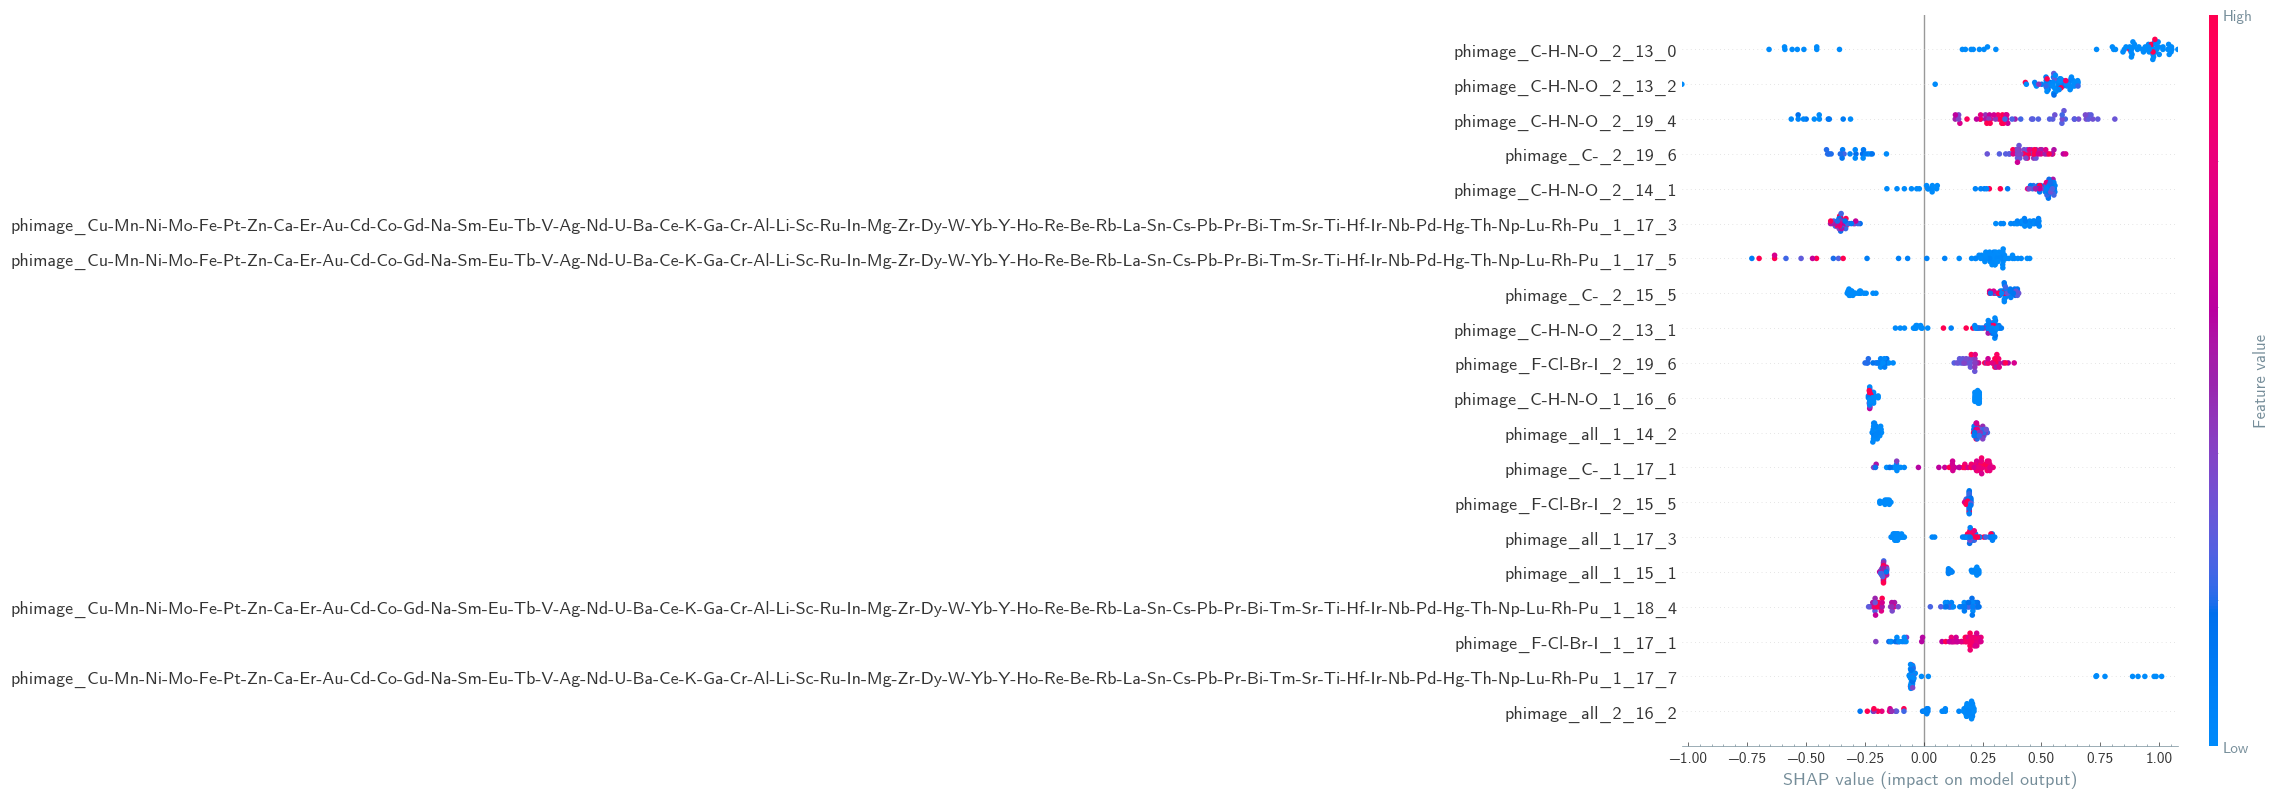

In [44]:
shap.summary_plot(
    shap_values,
    features=subset[subset["above_water_benchmark"]].sort_values(
        by="water_resistance", ascending=True
    )[feature_names],
    feature_names=feature_names,
)

In [45]:
dim_0_indices = []
dim_1_indices = []
dim_2_indices = []

c_indices = []
halogen_indices = []
metal_indices = []
all_indices = []
chno_indices = []

for i, name in enumerate(feature_names):
    dim = int(name.split("_")[-3])
    if dim == 0:
        dim_0_indices.append(i)
    elif dim == 1:
        dim_1_indices.append(i)
    elif dim == 2:
        dim_2_indices.append(i)

    elem = name.split("_")[1]

    if elem == "C-":
        c_indices.append(i)
    elif "Cu" in elem:
        metal_indices.append(i)
    elif "F" in elem:
        halogen_indices.append(i)
    elif "all" in elem:
        all_indices.append(i)
    else:
        chno_indices.append(i)

In [46]:
dim_0_importance = model.feature_importances_[np.array(dim_0_indices)].sum()
dim_1_importance = model.feature_importances_[np.array(dim_1_indices)].sum()
dim_2_importance = model.feature_importances_[np.array(dim_2_indices)].sum()

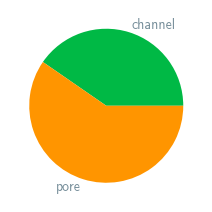

In [47]:
plt.pie(
    [dim_0_importance, dim_1_importance, dim_2_importance],
    labels=["", "channel", "pore"],
)
plt.savefig("../visuals/ph_dim_importance_water.pdf", bbox_inches="tight")
# plt.savefig('../visuals/ph_dim_importance_nCAC.png', dpi=400, bbox_inches='tight')

In [48]:
c_importance = model.feature_importances_[np.array(c_indices)].sum()
halogen_importance = model.feature_importances_[np.array(halogen_indices)].sum()
metal_importance = model.feature_importances_[np.array(metal_indices)].sum()
all_importance = model.feature_importances_[np.array(all_indices)].sum()
chno_importance = model.feature_importances_[np.array(chno_indices)].sum()

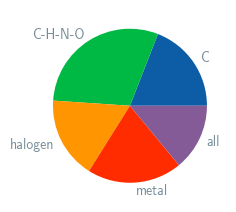

In [49]:
plt.pie(
    [
        c_importance,
        chno_importance,
        halogen_importance,
        metal_importance,
        all_importance,
    ],
    labels=["C", "C-H-N-O", "halogen", "metal", "all"],
)
# plt.savefig('ph_chem_importance.pdf', bbox_inches='tight')
plt.savefig("../visuals/ph_chem_importance_water.pdf", bbox_inches="tight")

### Now, let's look on a case-by-case basis what the most important features are


In [50]:
from mofdscribe.featurizers.topology.ph_image import PHImage
from ase.io import read, write

In [51]:
featurizer = PHImage(
    atom_types=(
        "C-H-N-O",
        "C-",
        "F-Cl-Br-I",
        "Cu-Mn-Ni-Mo-Fe-Pt-Zn-Ca-Er-Au-Cd-Co-Gd-Na-Sm-Eu-Tb-V"
        "-Ag-Nd-U-Ba-Ce-K-Ga-Cr-Al-Li-Sc-Ru-In-Mg-Zr-Dy-W-Yb-Y-"
        "Ho-Re-Be-Rb-La-Sn-Cs-Pb-Pr-Bi-Tm-Sr-Ti-Hf-Ir-Nb-Pd-Hg-"
        "Th-Np-Lu-Rh-Pu",
    ),
    spread=0.15,
    min_size=100,
    max_fit_tolerance=0.2,
)

featurizer.max_b = [0.0, 11.85585823059082, 11.856735992431641, 0.0]
featurizer.max_p = [8.401015663146973, 8.07491397857666, 4.6178689956665036, 0.0]

In [53]:
names = subset[subset['above_water_benchmark']].sort_values(by='water_resistance', ascending=False).iloc[:10]['MOF_x'].values

In [54]:
names

array(['str_m5_o2_o19_sra_sym.53', 'RSM1291', 'str_m3_o5_o13_pcu_sym.93',
       'str_m5_o5_o16_sra_sym.88', 'str_m5_o11_o16_sra_sym.128',
       'str_m5_o1_o16_sra_sym.97', 'str_m5_o2_o19_sra_sym.7',
       'str_m5_o10_o29_sra_sym.172', 'str_m5_o2_o19_sra_sym.141',
       'RSM2182'], dtype=object)

In [57]:
for name in names:
    write(f'../visuals/top_water_structures_ml/{name}.png', read(f'../data/CIF-Files/{name}.cif'))

In [58]:
def create_subset_structure(s, indices):
    return Structure.from_sites([s for i, s in enumerate(s) if i in indices])

In [60]:
for i in range(10):
    for j in range(8):
        name = names[i]
        try:
            feature_index = j
            sorted_index_array = np.argsort(shap_values[i,:])[::-1]
            sorted_feature_names = np.array(feature_names)[sorted_index_array]
            sorted_feature_names[feature_index]
            s = Structure.from_file(f'../data/CIF-Files//{name}.cif')
            mol= featurizer.find_relevant_substructure(s, sorted_feature_names[feature_index])
            show_atoms(create_atoms_with_color_arrays(s, mol.original_structure_indices), f'../visuals/top_water_fragments/{name}_{feature_index}_{sorted_feature_names[feature_index]}.pdf',)
            subset_structure = create_subset_structure(s, mol.original_structure_indices)
            subset_structure.to(f'../visuals/top_water_fragments/{name}_{feature_index}_{sorted_feature_names[feature_index]}.cif')
        except Exception as e:
            print(name, feature_index,  sorted_feature_names[feature_index], e)

HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
str_m5_o1_o16_sra_sym.97 7 phimage_F-Cl-Br-I_2_19_6 'NoneType' object is not iterable
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
str_m5_o2_o19_sra_sym.7 5 phimage_all_1_16_2 maximum recursion depth exceeded
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
str_m5_o2_o19_sra_sym.141 6 phimage_F-Cl-Br-I_2_19_6 'NoneType' object is not iterable
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
HELLOO
